In [1]:
import math
import numpy as np
import random
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

[ 0.33101182  0.35831211 -2.63251217  0.15361721  0.73685348 -2.31960964
 -1.58420149  0.00470857 -0.69712957 -1.03906899]
[ 0.36358808  0.33673885 -2.67799473  0.19629866  0.73670139 -2.31802424
 -1.59468099 -0.00341268 -0.71964919 -1.05279592]


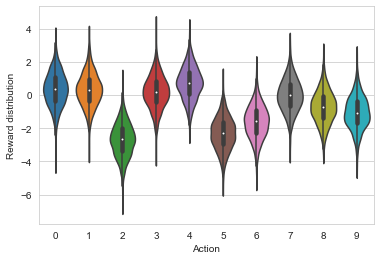

In [2]:
# The 10-armed Testbed
k = 10
action_values = np.random.normal(0, 1, k)
print(action_values)
optimal_action = np.argmax(action_values)
#print(optimal_action)
n = 2000
whole_reward = np.zeros((n, k))
for i in range(n):
    whole_reward[i, :] = np.random.normal(action_values[:], 1)
print(np.mean(whole_reward, axis=0))    # validation
sns.set_style('whitegrid')
sns.violinplot(data=whole_reward)
plt.xlabel('Action')
plt.ylabel('Reward distribution')
plt.show() # figure 2.1

In [3]:
# algorithm 0: random choice
def random_choice(k):
    candidate = [j for j in range(k)]
    action = random.choice(candidate)
    return action

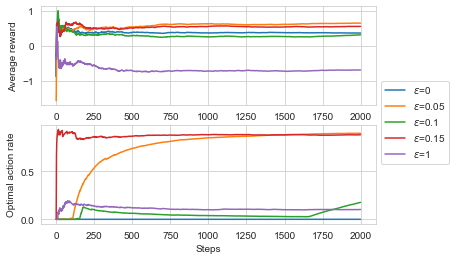

In [35]:
# algorithm 1: epsilon greedy
epsilon_list = [0, 0.05, 0.1, 0.15, 1]
for epsilon in epsilon_list:
    average_reward = []
    optimal_action_rate = []
    count_optimal_action = 0

    estimates = np.zeros((k,2))
    for i in range(2000):#n):
        max_value = np.max(estimates[:,1])
        e = np.random.rand()
        if e <= epsilon:    # exploration
            candidate = [j for j in range(k)]
        else:    # exploitation
            candidate = []
            for j in range(k):
                if estimates[j][1] == max_value:
                    candidate.append(j)
        action = random.choice(candidate)
        #print(action)
        reward = whole_reward[i][action]
        estimates[action][0] += 1
        estimates[action][1] = ( estimates[action][1] * (estimates[action][0] - 1) + reward) / estimates[action][0]

        if i == 0:
            average_reward.append(reward)
        else:
            average_reward.append( (average_reward[i-1]*i + reward) / (i+1) )

        if action == optimal_action:
            count_optimal_action += 1.0
        optimal_action_rate.append( count_optimal_action / (i + 1.0) )
    plt.subplot(211)
    plt.plot(average_reward)

    plt.subplot(212)
    plt.plot(optimal_action_rate, label = r'$\epsilon$=%s'%epsilon)
plt.legend(bbox_to_anchor=(1, 1.5))
plt.subplot(211)
plt.ylabel('Average reward')
plt.subplot(212)
plt.ylabel('Optimal action rate')
plt.xlabel('Steps')
plt.show() # figure 2.2

In [5]:
def epsilon_greedy(estimates, epsilon, alpha):
    max_value = np.max(estimates)
    e = np.random.rand()
    if e <= epsilon:    # exploration
        candidate = [j for j in range(k)]
    else:    # exploitation
        candidate = []
        for j in range(k):
            if estimates[j] == max_value:
                candidate.append(j)
    action = random.choice(candidate)
    reward = whole_reward[i][action]
    estimates[action] = estimates[action] + alpha * (reward - estimates[action])
    return action, reward

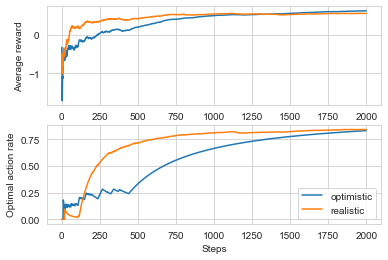

In [6]:
# Tracking a Nonostationary Problem
alpha = 0.1
# Optimistic Inital Values: simple trick that effective on stationary problems


optimistic_estimates = 5 * np.ones(k)
optimistic_average_reward = []
optimistic_optimal_action = 0
optimistic_optimal_rate = []
realistic_estimates = np.zeros(k)
realistic_average_reward = []
realistic_optimal_action = 0
realistic_optimal_rate = []

for i in range(n):
    optimistic_action, optimistic_reward = epsilon_greedy(optimistic_estimates, 0, alpha)
    realistic_action, realistic_reward = epsilon_greedy(realistic_estimates, 0.1, alpha)

    if i == 0:
        optimistic_average_reward.append(optimistic_reward)
        realistic_average_reward.append(realistic_reward)
    else:
        optimistic_average_reward.append( (optimistic_average_reward[i-1]*i + optimistic_reward) / (i+1) )
        realistic_average_reward.append( (realistic_average_reward[i-1]*i + realistic_reward) / (i+1) )
    
    if optimistic_action == optimal_action:
        optimistic_optimal_action += 1.0
    optimistic_optimal_rate.append( optimistic_optimal_action / (i + 1.0) )
    if realistic_action == optimal_action:
        realistic_optimal_action += 1.0
    realistic_optimal_rate.append( realistic_optimal_action / (i + 1.0) )
    
plt.subplot(211)
plt.plot(optimistic_average_reward, label = 'optimistic')
plt.plot(realistic_average_reward, label = 'realistic')
plt.ylabel('Average reward')
plt.subplot(212)
plt.plot(optimistic_optimal_rate, label = 'optimistic')
plt.plot(realistic_optimal_rate, label = 'realistic')
plt.ylabel('Optimal action rate')
plt.legend()
plt.xlabel('Steps')
plt.show() # figure 2.3

In [7]:
def upper_confidence_bound(estimates, t, alpha, c):
    min_count = np.min(estimates[:, 0])
    candidate = []
    if min_count == 0:
        for j in range(k):
            if estimates[j][0] == min_count:
                candidate.append(j)
    else:
        ucb = [estimates[j][1]+c*math.sqrt(np.log(t)/estimates[j][0]) for j in range(k)]
        max_value = np.max(ucb)
        for j in range(k):
            if ucb[j] == max_value:
                candidate.append(j)
    action = random.choice(candidate)
    reward = whole_reward[i][action]
    estimates[action][0] += 1
    estimates[action][1] = estimates[action][1] + alpha * (reward - estimates[action][1])
    return action, reward

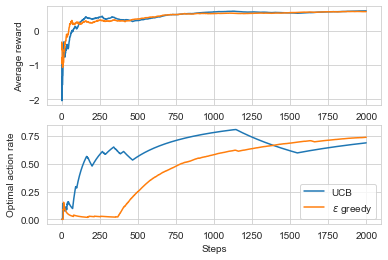

In [51]:
# Tracking a Nonostationary Problem
alpha = 0.1

ucb_estimates = np.zeros((k,2))
ucb_average_reward = []
ucb_optimal_action = 0
ucb_optimal_rate = []
egreedy_estimates = np.zeros(k)
egreedy_average_reward = []
egreedy_optimal_action = 0
egreedy_optimal_rate = []

for i in range(2000):#n):
    ucb_action, ucb_reward = upper_confidence_bound(ucb_estimates, i+1, alpha)
    egreedy_action, egreedy_reward = epsilon_greedy(egreedy_estimates, 0.1, alpha)

    if i == 0:
        ucb_average_reward.append(ucb_reward)
        egreedy_average_reward.append(egreedy_reward)
    else:
        ucb_average_reward.append( (ucb_average_reward[i-1]*i + ucb_reward) / (i+1) )
        egreedy_average_reward.append( (egreedy_average_reward[i-1]*i + egreedy_reward) / (i+1) )
    
    if ucb_action == optimal_action:
        ucb_optimal_action += 1.0
    ucb_optimal_rate.append( ucb_optimal_action / (i + 1.0) )
    if egreedy_action == optimal_action:
        egreedy_optimal_action += 1.0
    egreedy_optimal_rate.append( egreedy_optimal_action / (i + 1.0) )
    
plt.subplot(211)
plt.plot(ucb_average_reward)
plt.plot(egreedy_average_reward)
plt.ylabel('Average reward')
plt.subplot(212)
plt.plot(ucb_optimal_rate, label = 'UCB')
plt.plot(egreedy_optimal_rate, label = r'$\epsilon$ greedy')
plt.ylabel('Optimal action rate')
plt.legend()
plt.xlabel('Steps')
plt.show()

In [9]:
def softmax(x):
    mx = np.max(x)
    return np.exp(x-mx) / sum( np.exp(x-mx) )

In [10]:
def gradient_bandit(preference, policy, t, alpha, average):
    policy = softmax(preference)
    candidate = []
    max_value = np.max(policy)
    for j in range(k):
        if policy[j] == max_value:
            candidate.append(j)
    action = random.choice(candidate)
    reward = whole_reward[i][action]
    average = (average*(t-1) + reward) / t
    preference[action] = preference[action] + alpha * (reward - average) * (1-policy[action])
    for a in range(k):
        if a == action:
            continue
        preference[a] = preference[a] - alpha * (reward - average) * policy[a]
    return action, average

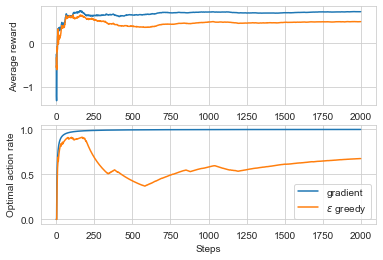

In [11]:
# Tracking a Nonostationary Problem
alpha = 0.1

gradient_estimates = np.zeros((k,2))
gradient_average_reward = []
gradient_optimal_action = 0
gradient_optimal_rate = []
gradient_average = 0
preference = np.zeros(k)
policy = np.zeros(k)

egreedy_estimates = np.zeros(k)
egreedy_average_reward = []
egreedy_optimal_action = 0
egreedy_optimal_rate = []

for i in range(2000):#n):
    gradient_action, gradient_average = gradient_bandit(preference, policy, i+1, alpha, gradient_average)
    egreedy_action, egreedy_reward = epsilon_greedy(egreedy_estimates, 0.1, alpha)

    gradient_average_reward.append(gradient_average)
    if i == 0:
        egreedy_average_reward.append(egreedy_reward)
    else:
        egreedy_average_reward.append( (egreedy_average_reward[i-1]*i + egreedy_reward) / (i+1) )
    
    if gradient_action == optimal_action:
        gradient_optimal_action += 1.0
    gradient_optimal_rate.append( gradient_optimal_action / (i + 1.0) )
    if egreedy_action == optimal_action:
        egreedy_optimal_action += 1.0
    egreedy_optimal_rate.append( egreedy_optimal_action / (i + 1.0) )
    
plt.subplot(211)
plt.plot(gradient_average_reward)
plt.plot(egreedy_average_reward)
plt.ylabel('Average reward')
plt.subplot(212)
plt.plot(gradient_optimal_rate, label = 'gradient')
plt.plot(egreedy_optimal_rate, label = r'$\epsilon$ greedy')
plt.ylabel('Optimal action rate')
plt.legend()
plt.xlabel('Steps')
plt.show()

[0.5, 0.25, 0.125, 0.0625, 0.03125, 0.015625, 0.0078125, 0.00390625, 0.001953125]
[-0.023817401582985728, 0.21523137973698334, 0.534154959552322, 0.3565320182818339, 0.6031895889347046, 0.7198024514514896, 0.6889240197261465, 0.6014555840536188, 0.7114909563384171]
[1.0, 0.5, 0.25, 0.125, 0.0625, 0.03125, 0.015625]
[-0.3339133746957475, -0.6883274177555312, 0.684121781492954, -0.04705618440393443, 0.7173943186929423, 0.7238942502650847, 0.6769519911813041]
[0.0625, 0.125, 0.25, 0.5, 1.0, 2.0, 4.0, 8.0]
[0.534918232200171, 0.4805090767397286, 0.5797406929023187, 0.615790007309541, 0.6080628162766363, 0.4894578627880655, 0.5307572859483295, 0.6010036555143997]
[0.125, 0.25, 0.5, 1.0, 2.0, 4.0, 8.0]
[0.632379103602742, 0.6089599092871132, 0.5849676939126789, 0.6485397804047386, 0.5014674295866578, 0.5092252710176027, 0.41839726190390025]


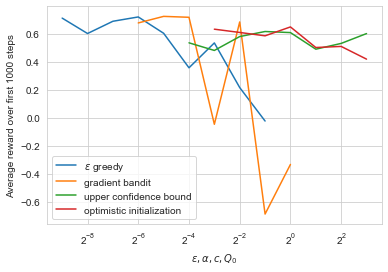

In [56]:
n = 1000
# parameter study
# epsilon greedy
e = 1
epsilon_list = []
while(e <= 256):
    e *= 2
    epsilon_list.append(1.0/e)
egreedy_average_reward = []
for epsilon in epsilon_list:
    egreedy_ar = 0
    egreedy_estimates = np.zeros(k)
    for i in range(n):
        egreedy_action, egreedy_reward = epsilon_greedy(egreedy_estimates, epsilon, alpha = 0.1)

        egreedy_ar = (egreedy_ar*i+egreedy_reward) / (i+1)
    egreedy_average_reward.append(egreedy_ar)
print(epsilon_list)
print(egreedy_average_reward)
plt.semilogx(epsilon_list, egreedy_average_reward, label = r'$\epsilon$ greedy', basex=2)

a = 1
alpha_list = []
while(a <= 64):
    alpha_list.append(1.0/a)
    a *= 2
gradient_average_reward = []
for alpha in alpha_list:
    gradient_ar = 0
    preference = np.zeros(k)
    policy = np.zeros(k)
    for i in range(n):
        gradient_action, gradient_ar = gradient_bandit(preference, policy, i+1, alpha, gradient_ar)
    gradient_average_reward.append(gradient_ar)
print(alpha_list)
print(gradient_average_reward)
plt.semilogx(alpha_list, gradient_average_reward, label = 'gradient bandit', basex=2)

c_list = []
c = 1.0/16
while(c <= 8):
    c_list.append(c)
    c *= 2
ucb_average_reward = []
for c in c_list:
    ucb_ar = 0
    ucb_estimates = np.zeros((k,2))
    
    for i in range(n):
        ucb_action, ucb_reward = upper_confidence_bound(ucb_estimates, i+1, alpha = 0.1)
        ucb_ar = (ucb_ar*i+ucb_reward) / (i+1)

    ucb_average_reward.append(ucb_ar)
print(c_list)
print(ucb_average_reward)
plt.semilogx(c_list, ucb_average_reward, label = 'upper confidence bound', basex=2)

q_list = []
q = 1.0/8
while(q <= 8):
    q_list.append(q)
    q *= 2
optimistic_average_reward = []
for q in q_list:
    optimistic_ar = 0
    optimistic_estimates = q * np.ones(k)
    for i in range(n):
        optimistic_action, optimistic_reward = epsilon_greedy(optimistic_estimates, 0, alpha = 0.1)
        optimistic_ar = (optimistic_ar*i+optimistic_reward) / (i+1)

    optimistic_average_reward.append(optimistic_ar)
    
print(q_list)
print(optimistic_average_reward)
plt.semilogx(q_list, optimistic_average_reward, label = 'optimistic initialization', basex=2)

plt.xlabel(r'$\epsilon, \alpha, c, Q_0$')
plt.ylabel('Average reward over first 1000 steps')
plt.legend()
plt.show()